# COMP90051 Project 2

In [188]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [189]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [190]:
# Define global functions here, if required


## 1. Implement ε-greedy and UCB MABs

In [191]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        # your code here
        
        self.epsilon = epsilon
        
        # initialize values
        self.count_per_arm = [0 for arm in range(n_arms)]
        
        # Initialize all the arms with zero total reward
        self.q_values = [Q0 for arm in range(n_arms)]
        
        # Initialize all the arms with zero total reward
        self.total_reward_per_arm = [0 for arm in range(n_arms)] 


    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        # perform exploration
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.q_values, 1)
        # perform exploitation
        else:
            # Get highest q-value from current q-values
            highest = max(self.q_values)
            highest_Qs = [index for index, value in enumerate(self.q_values) if value == highest]
            
            if len(highest_Qs) > 1:
                action = np.random.choice(highest_Qs) #random tie breaking
            else:
                action = highest_Qs[0]
        return action
        
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
                
        # update the step of individual arms
        self.count_per_arm[arm] += 1
        
        # update total reward
        self.total_reward_per_arm[arm] += reward
        
        # update q-values each arm
        updated_reward =  self.total_reward_per_arm[arm] / self.count_per_arm[arm]
        self.q_values[arm] = updated_reward
        
        return

In [192]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        # your code here

        # set rho
        self.rho = rho
        
        # Step count for each arm
        self.count_per_arm = [0 for arm in range(n_arms)]
        self.total_rounds = 0
        
        # Mean reward for each arm
        self.q_values = [Q0 for arm in range(n_arms)]
        
        # Initialize all arms with zero reward
        self.total_reward_per_arm = [0 for arm in range(n_arms)] 
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        #copy each arm with reward for later calculation at tround
        previous_values = self.q_values
        
        for arm in range(self.n_arms):
            if self.count_per_arm[arm] == 0: # Use intial values for the first round
                continue
                
            else:
                # Calculate q-value with exlpore boost for each arm
                estimate_explore = self.rho * np.log(self.total_rounds) / self.count_per_arm[arm]
                
                previous_values[arm] = previous_values[arm] + np.sqrt(estimate_explore)
            
        # Get the highest value from current values
        highest = max(previous_values)
        # find all elements with highest values 
        highest_Qs = [index for index, value in enumerate(previous_values) if value == highest]
        
        if len(highest_Qs) > 1:
            action = np.random.choice(highest_Qs) # perform random tie breaking
        else:
            action = highest_Qs[0]
        
        return action
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here

        # update the step of individual arms
        self.count_per_arm[arm] += 1
        
        self.total_rounds += 1
        
        # update total reward
        self.total_reward_per_arm[arm] += reward
        
        # update q-values each arm
        updated_reward =  self.total_reward_per_arm[arm] / self.count_per_arm[arm]
        self.q_values[arm] = updated_reward
        return

## 2. Implement off-policy evaluation

In [193]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    assert(rewards.shape==(num_of_events,)),"must be 1d array"
    assert(n_rounds > 0 or n_rounds is None),"n_rounds must be positive integer or None (repeat until end)"
    h0 = [] # history list
    R0 = [] # total payoff list
        
    count = 0
    for event in range(num_of_events):
        #If reached maximum number of rounds then stop (or repeat until last event)
        if len(h0) == n_rounds:     
            break
            
        #Play an arm
        action = mab.play(contexts[event])
        #print(action)
        
        #If the chosen arm is equal to the arm in the log
        # we record the history, the payoff and update the arm
        if action == arms[event]:
            # increase count of valid events
            count +=1
            
            h0.append(event)
            R0.append(rewards[event])
            mab.update(arms[event],rewards[event],contexts[event])
    
    return R0

In [194]:
# load dataset here

#Initial three lists which respects
# to arm, reward, and context(feature_list in this case).
arm_list = []
reward_list = []
features_list = []
num_of_events = 0

#Read each line and split by spaces. Record arm, reward and context into the lists
with open("dataset.txt","r") as f:
    dataset = f.readlines()
    
for line in dataset:
    num_of_events += 1
    current_line = line.split()
    
    # get arm from dataset
    arm = int(current_line[0])
    
    # get reward from dataset
    reward = float(current_line[1])
    
    # get features from dataset
    features = current_line[2:]
    features = [float(element) for element in features]
    
    arm_list.append(arm)
    reward_list.append(reward)
    features_list.append(features)
    
#Convert lists into np_array
arms = np.array(arm_list)
rewards = np.array(reward_list)

#For each event, the context is 10*10 dim 
# because there are 10 arms, and each one of them has 10 features 
contexts = np.array(features_list).reshape(num_of_events,(10*10))

In [195]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.14375


In [196]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.115


## 3. Implement LinUCB contextual MAB

In [197]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        assert (n_arms > 0),"n_arms must be positive"
        assert (n_dims > 0),"n_dims must be positive"
        assert ((type(alpha)==float or type(alpha) == np.float64) and alpha >0.0 and np.isreal(alpha)), "alpha must be real positive floating point number"
        self.n_dims = n_dims
        self.alpha = alpha
        
        self.A_a = [np.identity(n_dims) for arm in range(n_arms)]
        self.b_a = [np.zeros(n_dims) for arm in range(n_arms)]

        
        #self.A_a = [] #A is the list of each arm with D.T * D + I 
        #self.b_a = [] #b is the reward list

    def play(self, context):
        super().play(context)
        # your code here        
        assert (context.shape == (self.n_arms*self.n_dims,)),"context must be a numeric array of length self.n_dims * self.n_arms"
        arm_with_Q = [float('inf') for arm in range(self.n_arms)] #At tround, initial arm with empty posterior distribution
        
        context = context.reshape(self.n_arms, self.n_dims)
        
        for arm in range(0,self.n_arms):
            #For each arm, calculate posterior distribution based on theta and std
            Theta_a = np.dot(np.linalg.inv(self.A_a[arm]), self.b_a[arm])
            std = np.sqrt(np.linalg.multi_dot([np.transpose(context[arm]), np.linalg.inv(self.A_a[arm]), context[arm]]))
            p_ta = np.dot(Theta_a.T,context[arm]) + self.alpha * std
            
            if not np.isnan(p_ta):#make sure the result of calculation is valid number
                arm_with_Q[arm] = p_ta
            
        #Getting the highest value from posterior distribution, then find the corresponding key and append them
        highest = max(arm_with_Q)
        
        highest_Qs = [index for index, value in enumerate(arm_with_Q) if value == highest]

        if len(highest_Qs)>1:
            action = np.random.choice(highest_Qs) # tie breaker
        else:
            action = highest_Qs[0]
        
        return action
        
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        assert (arm >= 0 and arm <=self.n_arms),"arm must be positive integers and no larger than self.n_arms"
        assert (type(reward)==float or type(reward) == np.float64),"reward must be floating point"
        assert (context.shape == (self.n_arms*self.n_dims,)),"context must be a numeric array of length self.n_dims * self.n_arms"
        
        context = context.reshape(self.n_arms,self.n_dims)
        
        
        if arm <= self.n_arms:
            #Reshap the vector to matrix, or the calculation will be incorrect because the transpose will not take effects
            context_Matrix = context[arm].reshape(-1,1)
            context_times_contextT = np.dot(context_Matrix,context_Matrix.T)
            
            self.A_a[arm] = np.add(self.A_a[arm], context_times_contextT)
            
            self.b_a[arm] = np.add(self.b_a[arm], np.dot(reward,context[arm]))

In [198]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [199]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        # your code here
        assert (n_arms > 0),"n_arms must be positive integers"
        assert (n_dims > 0),"n_dims must be positive integers"
        
    def play(self, context):
        super().play(context)
        # your code here
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here

In [200]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward nan


/Users/bachfischer/opt/anaconda3/envs/stat-ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bachfischer/opt/anaconda3/envs/stat-ml/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

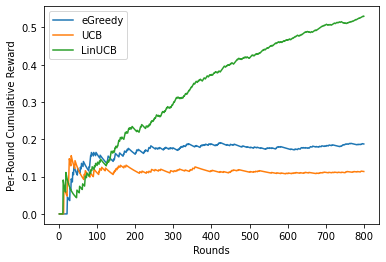

In [205]:
# TODO: Add code for TreeBootstrap

# TODO: Remove code from below
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)


# your code here
EpsGreedy_reward = []
UCB_reward = []
linUCB_reward = []
total_round = []
count = 0

for round in range(0,800):
    count +=1
    if round == 0: #calculate initial reward 
        EpsGreedy_reward.append(results_EpsGreedy[round]/count)
        UCB_reward.append(results_UCB[round]/count)
        linUCB_reward.append(results_LinUCB[round]/count)
    else:  # calculate cumulated reward
        results_EpsGreedy[round] += results_EpsGreedy[round-1] 
        EpsGreedy_reward.append(results_EpsGreedy[round]/count)
        
        results_UCB[round]+= results_UCB[round-1]
        UCB_reward.append(results_UCB[round]/count)
        
        results_LinUCB[round]+= results_LinUCB[round-1]
        linUCB_reward.append(results_LinUCB[round]/count)
        
plt.plot(np.linspace(1,800,800),EpsGreedy_reward, label = "eGreedy")
plt.plot(np.linspace(1,800,800),UCB_reward, label = "UCB")
plt.plot(np.linspace(1,800,800),linUCB_reward, label = "LinUCB")
plt.ylabel('Per-Round Cumulative Reward')
plt.xlabel('Rounds')
plt.legend()
plt.show()

### 5.B.

In [ ]:
# your code here

## 6. Implement KernelUCB contextual MAB

In [ ]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        
    def play(self, context):
        super().play(context)
        # your code here
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here

In [ ]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

In [ ]:
# your plotting code here